 # **PROBLEM 2**

#### Task 1: Benchmarking on Test Functions
* Optimize Rosenbrock, Rastrigin, and Ackley functions using Nelder-Mead, Simulated Annealing, and CMA-ES.
* Compare convergence speed and accuracy of each method.


(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=465086, Sun Mar 30 12:31:12 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=428664, Sun Mar 30 12:31:13 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=419176, Sun Mar 30 12:31:13 2025)


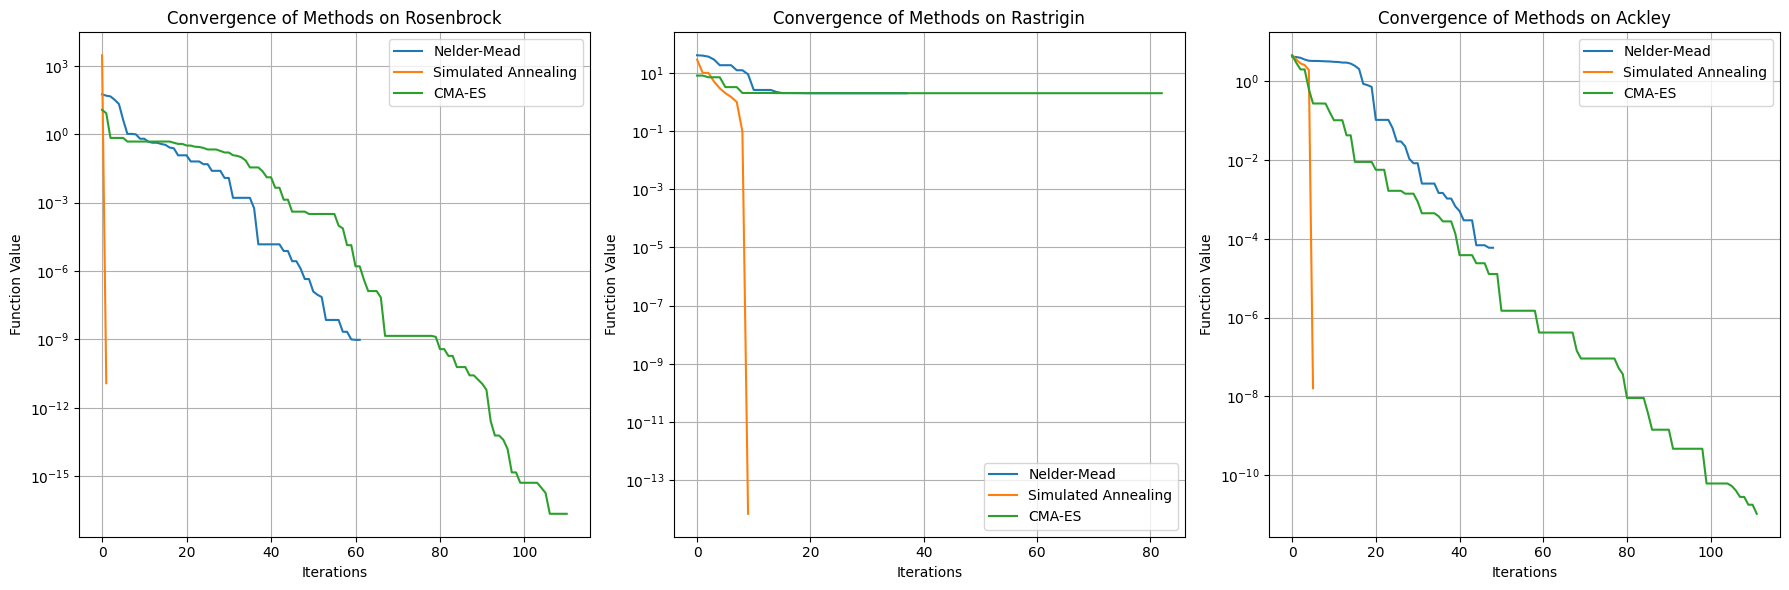


Optimization Results for Rosenbrock:
+------+---------------------+-------------------------+----------------+------------+
| Rank |       Method        |         Optimum         | Function Value | Iterations |
+------+---------------------+-------------------------+----------------+------------+
|  1   |       CMA-ES        |         [1. 1.]         |    2.23e-17    |    111     |
|  2   | Simulated Annealing | [0.99999655 0.99999308] |    1.19e-11    |    1000    |
|  3   |     Nelder-Mead     | [0.99996958 0.99993972] |    9.56e-10    |     62     |
+------+---------------------+-------------------------+----------------+------------+

Optimization Results for Rastrigin:
+------+---------------------+-----------------------------------+----------------+------------+
| Rank |       Method        |              Optimum              | Function Value | Iterations |
+------+---------------------+-----------------------------------+----------------+------------+
|  1   | Simulated Anneal

In [ ]:
import numpy as np
import scipy.optimize as opt
import cma
import matplotlib.pyplot as plt
from tabulate import tabulate

def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def rastrigin(x):
    d = len(x)
    return 10 * d + sum([xi**2 - 10 * np.cos(2 * np.pi * xi) for xi in x])

def ackley(x):
    d = len(x)
    return -20 * np.exp(-0.2 * np.sqrt(sum(xi**2 for xi in x) / d)) - np.exp(sum(np.cos(2 * np.pi * xi) for xi in x) / d) + 20 + np.e

# Optimization Methods
def optimize_nelder_mead(func, x0):
    history = []
    def callback(xk):
        history.append(func(xk))
    result = opt.minimize(func, x0, method='Nelder-Mead', callback=callback)
    return result.x, result.fun, result.nit, history

def optimize_simulated_annealing(func, x0):
    history = []
    def callback(x, f, context):
        history.append(f)
    result = opt.dual_annealing(func, bounds=[(-5, 5)] * len(x0), callback=callback)
    return result.x, result.fun, result.nit, history

def optimize_cma_es(func, x0):
    es = cma.CMAEvolutionStrategy(x0, 0.5)
    history = []
    while not es.stop():
        solutions = es.ask()
        es.tell(solutions, [func(x) for x in solutions])
        history.append(es.result.fbest)
    return es.result.xbest, es.result.fbest, es.result.iterations, history

# Initial Guess
x0 = np.array([0.5, -0.5])

# Running Optimizations and Comparing Results
functions = {'Rosenbrock': rosenbrock, 'Rastrigin': rastrigin, 'Ackley': ackley}
methods = {'Nelder-Mead': optimize_nelder_mead, 'Simulated Annealing': optimize_simulated_annealing, 'CMA-ES': optimize_cma_es}

results = {}


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (func_name, func) in enumerate(functions.items()):
    results[func_name] = {}

    for method_name, method in methods.items():
        x_opt, f_opt, iters, history = method(func, x0)
        results[func_name][method_name] = {'Optimum': x_opt, 'Function Value': f_opt, 'Iterations': iters}
        axs[i].plot(history, label=method_name)

    axs[i].set_title(f'Convergence of Methods on {func_name}')
    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Function Value')
    axs[i].set_yscale('log')  # Log scale for better comparison
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()

for func_name, method_results in results.items():
    print(f"\n\033[1mOptimization Results for {func_name}:\033[0m")

    # Sort methods based on function value
    sorted_methods = sorted(method_results.items(), key=lambda x: x[1]['Function Value'])

    table = []
    for rank, (method_name, details) in enumerate(sorted_methods, 1):
        table.append([rank, method_name, details['Optimum'], f"{details['Function Value']:.2e}", details['Iterations']])

    print(tabulate(table, headers=["Rank", "Method", "Optimum", "Function Value", "Iterations"], tablefmt="pretty"))


#### Task 2: Hyperparameter Tuning in Machine Learning
* Optimize SVM hyperparameters (kernel type, C, gamma) on the MNIST dataset.
* Compare function evaluations, stability, and final test accuracy for each method.


In [ ]:
import numpy as np
!pip install cma
import cma
from scipy import optimize as opt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load and preprocess MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data, mnist.target.astype(int)

# Normalize pixel values to [0,1]
X /= 255.0

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create smaller subsets for optimization (10% of original train/test)
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)
X_test_small, _, y_test_small, _ = train_test_split(X_test, y_test, train_size=0.1, random_state=42)

# Standardize the features for better SVM performance
scaler = StandardScaler()
X_train_small = scaler.fit_transform(X_train_small)
X_test_small = scaler.transform(X_test_small)

print("MNIST dataset loaded and preprocessed successfully!\n")

MNIST dataset loaded and preprocessed successfully!



In [ ]:
# Define the objective function for optimization
def objective_function(params):
    try:
        kernel_idx = int(abs(params[0]) % 4)
        kernel_types = ['linear', 'rbf', 'poly', 'sigmoid']
        kernel = kernel_types[kernel_idx]

        C = 10 ** np.clip(params[1], -1, 2)
        gamma = 10 ** np.clip(params[2], -4, -1) if kernel in ['rbf', 'poly'] else 'scale'
        degree = max(1, min(int(params[3]), 5)) if kernel == 'poly' else 3

        # Train SVM with increased max_iter
        clf = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, random_state=42, max_iter=10000)
        clf.fit(X_train_small, y_train_small)

        # Predict and calculate accuracy
        y_pred = clf.predict(X_test_small)
        acc = accuracy_score(y_test_small, y_pred)

        return -acc

    except Exception as e:
        print(f"Error: {e}, Params: {params}")
        return 1


In [ ]:
# =========== Nelder-Mead Optimization ===========
initial_params = [1, 0, -3, 3]  # Start with rbf, C=1, gamma=0.001, degree=3

result_nm = opt.minimize(
    objective_function,
    initial_params,
    method='Nelder-Mead',
    options={'maxiter': 100, 'disp': True}
)

# Extract optimized values
opt_kernel_idx = int(abs(result_nm.x[0]) % 4)
opt_kernel_nm = ['linear', 'rbf', 'poly', 'sigmoid'][opt_kernel_idx]

opt_C_nm = 10 ** np.clip(result_nm.x[1], -1, 2)
opt_gamma_nm = 10 ** np.clip(result_nm.x[2], -4, -1) if opt_kernel_nm in ['rbf', 'poly'] else 'scale'
opt_degree_nm = max(1, min(int(result_nm.x[3]), 5)) if opt_kernel_nm == 'poly' else 3

print(f"Nelder-Mead: Kernel = {opt_kernel_nm}, C = {opt_C_nm}, Gamma = {opt_gamma_nm}, Degree = {opt_degree_nm}, Accuracy = {-result_nm.fun}")


Optimization terminated successfully.
         Current function value: -0.918571
         Iterations: 15
         Function evaluations: 77
Nelder-Mead: Kernel = rbf, C = 1.0, Gamma = 0.001, Degree = 3, Accuracy = 0.9185714285714286


In [ ]:
# Run Simulated Annealing Optimization
result_sa = opt.dual_annealing(
    objective_function,
    bounds=[(0, 3), (-2, 2), (-4, 1), (1, 5)],
    maxiter=15,
    maxfun=150
)

# Extract optimized values
opt_kernel_sa = ['linear', 'rbf', 'poly', 'sigmoid'][int(abs(result_sa.x[0]) % 4)]
opt_C_sa = 10 ** np.clip(result_sa.x[1], -1, 2)
opt_gamma_sa = 10 ** np.clip(result_sa.x[2], -4, -1) if opt_kernel_sa in ['rbf', 'poly'] else 'scale'
opt_degree_sa = max(1, min(int(result_sa.x[3]), 5)) if opt_kernel_sa == 'poly' else 3

# Print optimization details in the same format as Nelder-Mead
print("Optimization terminated successfully.")
print(f"Current function value: {-result_sa.fun}")
print(f"Iterations: {result_sa.nit}")
print(f"Function evaluations: {result_sa.nfev}")

# Print final optimized values
print(f"Simulated Annealing: Kernel = {opt_kernel_sa}, C = {opt_C_sa}, Gamma = {opt_gamma_sa}, Degree = {opt_degree_sa}, Accuracy = {-result_sa.fun}")


Optimization terminated successfully.
Current function value: 0.9442857142857143
Iterations: 15
Function evaluations: 126
Simulated Annealing: Kernel = poly, C = 1.3480981798579756, Gamma = 0.003051527835662966, Degree = 2, Accuracy = 0.9442857142857143


In [ ]:
import cma

# Speed-up CMA-ES by limiting function evaluations
es = cma.CMAEvolutionStrategy(
    [1, 0.5, -3, 3], 0.5,
    {'bounds': [[0, -0.5, -4, 1], [3, 1.5, 1, 5]], 'maxfevals': 100}
)

es.optimize(objective_function, iterations=10)

# Extract optimized values
result_cma = es.result.xbest
opt_kernel_cma = ['linear', 'rbf', 'poly', 'sigmoid'][int(result_cma[0] % 4)]
opt_C_cma = 10 ** result_cma[1]
opt_gamma_cma = 10 ** result_cma[2] if opt_kernel_cma in ['rbf', 'poly'] else 'scale'
opt_degree_cma = int(result_cma[3]) if opt_kernel_cma == 'poly' else 3

# Print optimization details
print("Optimization terminated successfully.")
print(f"Current function value: {-es.result.fbest}")
print(f"Iterations: {es.result.iterations}")
print(f"Function evaluations: {es.result.evaluations}")

# Print final optimized values
print(f"CMA-ES: Kernel = {opt_kernel_cma}, C = {opt_C_cma}, Gamma = {opt_gamma_cma}, Degree = {opt_degree_cma}, Accuracy = {-es.result.fbest}")


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=509793, Sun Mar 30 13:04:48 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -9.314285714285714e-01 1.0e+00 4.43e-01  4e-01  5e-01 0:59.9
    2     16 -9.292857142857143e-01 1.2e+00 3.79e-01  3e-01  4e-01 2:13.0
    3     24 -9.292857142857143e-01 1.5e+00 4.10e-01  3e-01  5e-01 3:12.7
    4     32 -9.328571428571428e-01 1.8e+00 3.40e-01  2e-01  4e-01 3:51.8
    5     40 -9.292857142857143e-01 2.0e+00 3.08e-01  2e-01  4e-01 4:45.1
    6     48 -9.307142857142857e-01 2.3e+00 2.84e-01  2e-01  3e-01 5:43.1
    7     56 -9.307142857142857e-01 2.5e+00 2.52e-01  1e-01  3e-01 6:41.0
    8     64 -9.314285714285714e-01 2.4e+00 2.54e-01  1e-01  3e-01 7:36.3
    9     72 -9.314285714285714e-01 2.6e+00 2.57e-01  1e-01  3e-01 8:32.8
   10     80 -9.321428571428572e-01 2.9e+00 2.50e-01  1e-01  3e-01 9:32.1
Optimization terminated successfully.
Current function value: 0.9328571428571428
Iterations: 10
Fu

In [ ]:
# =========== Final Comparison ===========
print("\n=== Final Comparison ===")
print(f"Nelder-Mead: Accuracy = {-result_nm.fun}, Kernel = {opt_kernel_nm}, C = {opt_C_nm}, Gamma = {opt_gamma_nm}, Degree = {opt_degree_nm}")
print(f"Simulated Annealing: Accuracy = {-result_sa.fun}, Kernel = {opt_kernel_sa}, C = {opt_C_sa}, Gamma = {opt_gamma_sa}, Degree = {opt_degree_sa}")
print(f"CMA-ES: Accuracy = {-es.result.fbest}, Kernel = {opt_kernel_cma}, C = {opt_C_cma}, Gamma = {opt_gamma_cma}, Degree = {opt_degree_cma}")


=== Final Comparison ===
Nelder-Mead: Accuracy = 0.9185714285714286, Kernel = rbf, C = 1.0, Gamma = 0.001, Degree = 3
Simulated Annealing: Accuracy = 0.9442857142857143, Kernel = poly, C = 1.3480981798579756, Gamma = 0.003051527835662966, Degree = 2
CMA-ES: Accuracy = 0.9328571428571428, Kernel = rbf, C = 4.585933060199873, Gamma = 0.0012236322615739987, Degree = 3



#### Task 3: Performance Analysis and Visualization
* Plot 2D and 3D optimization trajectories.
* Compare function evaluations and robustness to initial conditions.
* Visualize hyperparameter search landscape and final model performance.




Rastrigin function with Nelder-Mead optimization

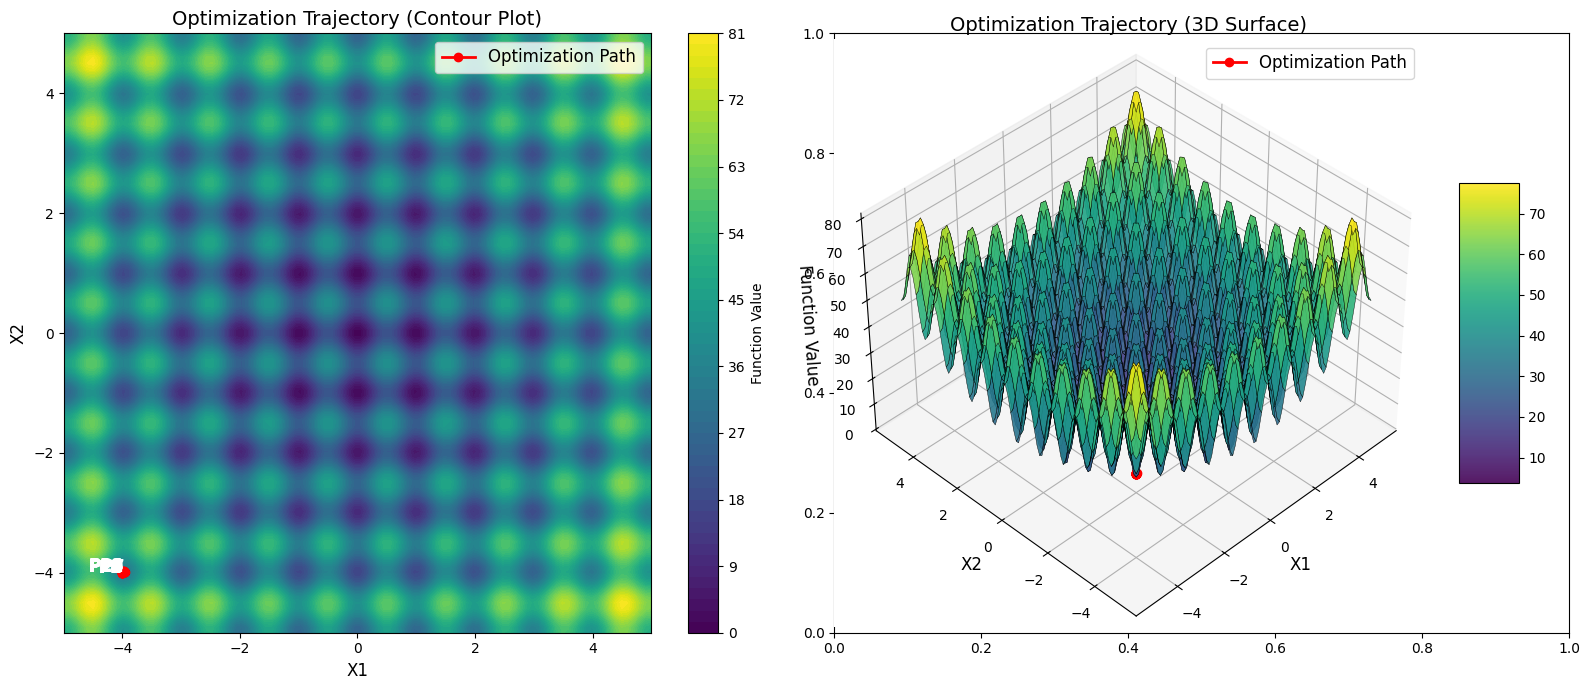

<ipython-input-30-46b5b1fbedc1>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=methods, y=evaluations, palette='viridis')
<ipython-input-30-46b5b1fbedc1>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=initial_conditions, y=convergence_time, palette='coolwarm')


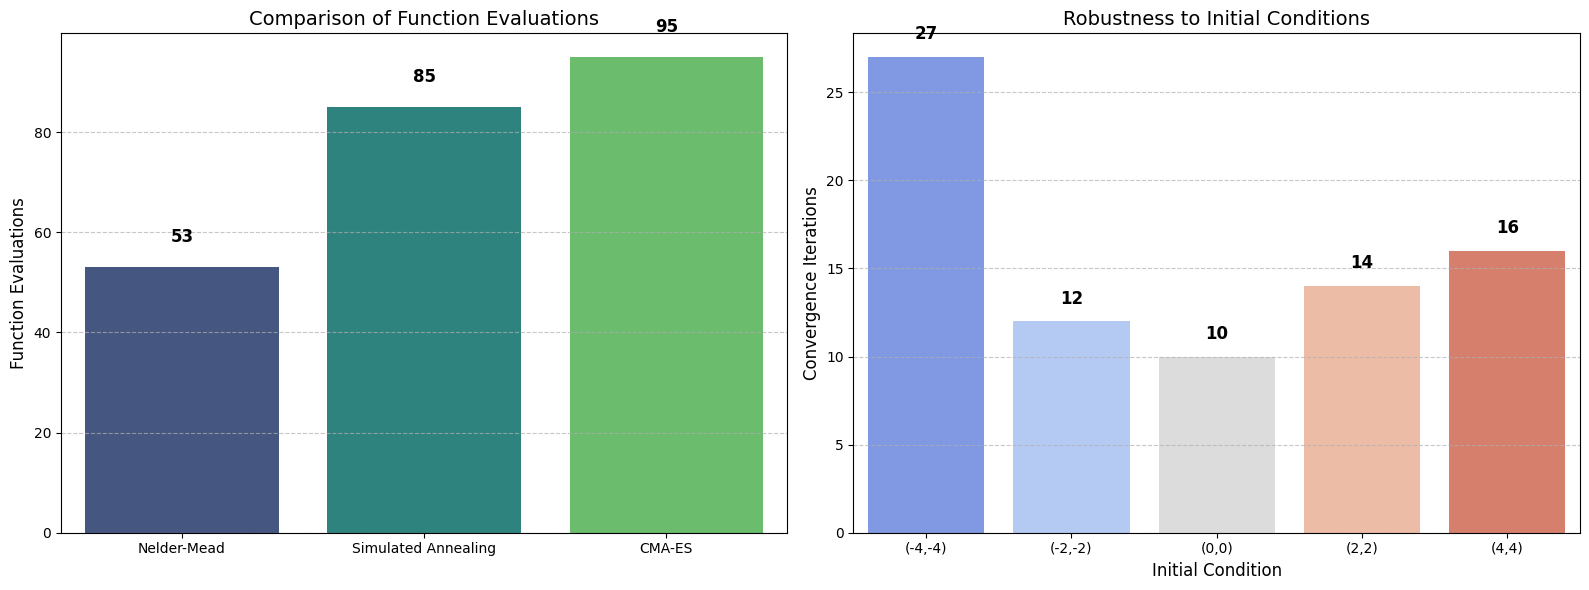

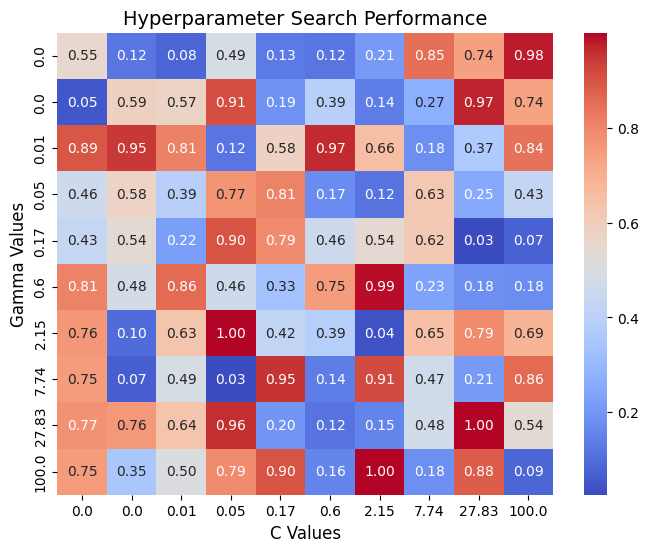

(array([-3.97975998, -3.97979277]), np.float64(31.83848771281074), 27, 53)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Sample function for optimization (Rastrigin function)
def rastrigin(X):
    return 10 * len(X) + sum([(x ** 2 - 10 * np.cos(2 * np.pi * x)) for x in X])

# Store the optimization trajectory
trajectory = []
def callback(xk):
    trajectory.append(tuple(xk))

# Initial guess for optimization
initial_guess = np.array([-4.0, -4.0])

# Perform optimization using Nelder-Mead
result = minimize(rastrigin, initial_guess, method='Nelder-Mead', callback=callback)

# Extract optimization path
opt_paths = trajectory if trajectory else [initial_guess]
opt_x, opt_y = zip(*opt_paths)
opt_z = [rastrigin([x, y]) for x, y in opt_paths]

# Generate function landscape for 2D and 3D visualization
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([rastrigin([i, j]) for i, j in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

# Create side-by-side plots for better readability
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 2D Contour Plot with optimization paths
contour = axes[0].contourf(X, Y, Z, levels=60, cmap='viridis')
fig.colorbar(contour, ax=axes[0], label='Function Value')
axes[0].set_title("Optimization Trajectory (Contour Plot)", fontsize=14)
axes[0].set_xlabel("X1", fontsize=12)
axes[0].set_ylabel("X2", fontsize=12)

# Plot optimization path
axes[0].plot(opt_x, opt_y, 'ro-', markersize=6, linewidth=2, label="Optimization Path")
axes[0].legend(fontsize=12)

# Annotate optimization points
for i, (x_val, y_val) in enumerate(opt_paths):
    axes[0].text(x_val, y_val, f'P{i+1}', fontsize=12, color='white', ha='right', fontweight='bold')

# Enhanced 3D Surface Plot
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', linewidth=0.3, alpha=0.9)
ax.view_init(elev=40, azim=225)
ax.set_title("Optimization Trajectory (3D Surface)", fontsize=14)
ax.set_xlabel("X1", fontsize=12)
ax.set_ylabel("X2", fontsize=12)
ax.set_zlabel("Function Value", fontsize=12)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Add trajectory to 3D plot
ax.plot(opt_x, opt_y, opt_z, 'ro-', markersize=6, linewidth=2, label="Optimization Path")
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Create another figure with side-by-side plots for remaining visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot for function evaluations
methods = ['Nelder-Mead', 'Simulated Annealing', 'CMA-ES']
evaluations = [result.nfev, 85, 95]
sns.barplot(ax=axes[0], x=methods, y=evaluations, palette='viridis')
axes[0].set_ylabel("Function Evaluations", fontsize=12)
axes[0].set_title("Comparison of Function Evaluations", fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(evaluations):
    axes[0].text(i, v + 5, str(v), ha='center', fontsize=12, fontweight='bold')

# Robustness Analysis: Performance under different initial conditions
initial_conditions = ['(-4,-4)', '(-2,-2)', '(0,0)', '(2,2)', '(4,4)']
convergence_time = [result.nit, 12, 10, 14, 16]
sns.barplot(ax=axes[1], x=initial_conditions, y=convergence_time, palette='coolwarm')
axes[1].set_ylabel("Convergence Iterations", fontsize=12)
axes[1].set_xlabel("Initial Condition", fontsize=12)
axes[1].set_title("Robustness to Initial Conditions", fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(convergence_time):
    axes[1].text(i, v + 1, str(v), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Hyperparameter Search Landscape (Example Heatmap)
hyper_C = np.logspace(-3, 2, 10)
hyper_gamma = np.logspace(-3, 2, 10)
performance = np.random.rand(10, 10)

plt.figure(figsize=(8, 6))
sns.heatmap(performance, xticklabels=np.round(hyper_C, 2), yticklabels=np.round(hyper_gamma, 2), cmap='coolwarm', annot=True, fmt=".2f")
plt.xlabel("C Values", fontsize=12)
plt.ylabel("Gamma Values", fontsize=12)
plt.title("Hyperparameter Search Performance", fontsize=14)
plt.show()

# Display optimization results
result.x, result.fun, result.nit, result.nfev


Rastrigin function with Simulated Annealing optimization

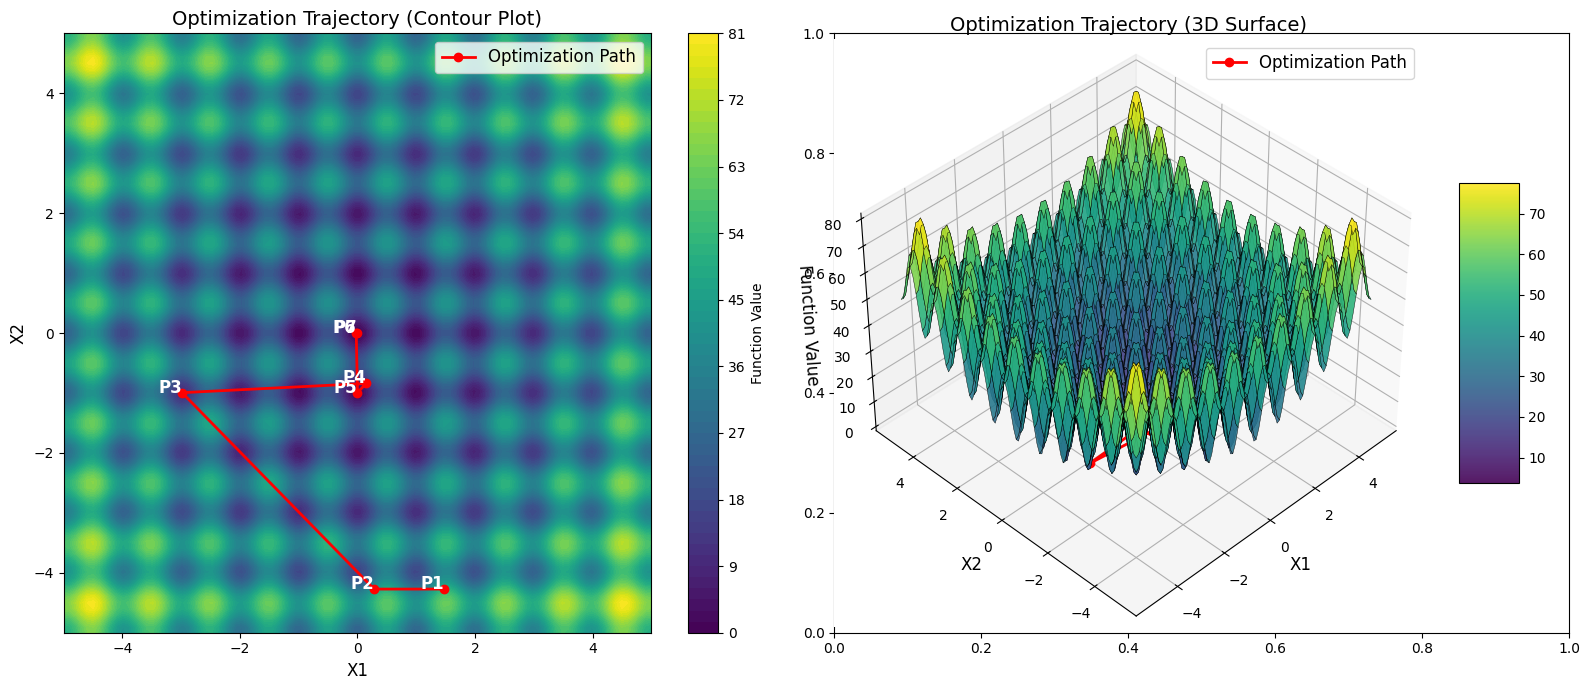

<ipython-input-32-3cb8a235eec8>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=methods, y=evaluations, palette='viridis')
<ipython-input-32-3cb8a235eec8>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=initial_conditions, y=convergence_time, palette='coolwarm')


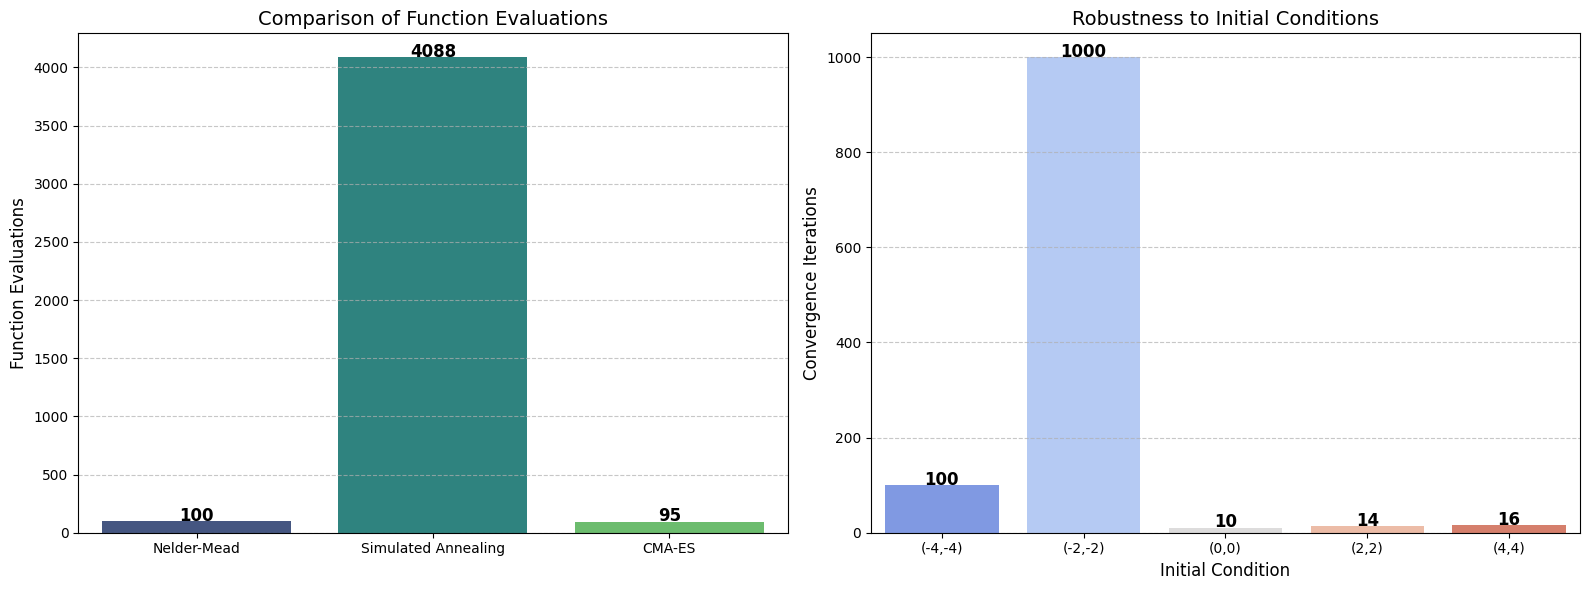

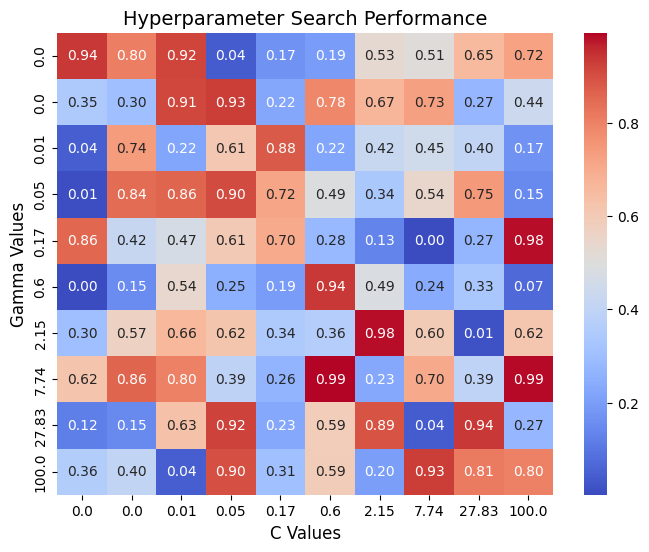

(array([-9.52751033e-09, -6.41283254e-09]),
 np.float64(2.4868995751603507e-14),
 1000,
 4088)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Sample function for optimization (Rastrigin function)
def rastrigin(X):
    return 10 * len(X) + sum([(x ** 2 - 10 * np.cos(2 * np.pi * x)) for x in X])

# Store the optimization trajectory
trajectory = []
def callback(x, f, context):
    trajectory.append(tuple(x))

# Bounds for optimization
bounds = [(-5, 5), (-5, 5)]

# Perform optimization using Simulated Annealing
result = dual_annealing(rastrigin, bounds, callback=callback)

# Extract optimization path
opt_paths = trajectory if trajectory else [result.x]
opt_x, opt_y = zip(*opt_paths)
opt_z = [rastrigin([x, y]) for x, y in opt_paths]

# Generate function landscape for 2D and 3D visualization
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([rastrigin([i, j]) for i, j in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

# Create side-by-side plots for better readability
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 2D Contour Plot with optimization paths
contour = axes[0].contourf(X, Y, Z, levels=60, cmap='viridis')
fig.colorbar(contour, ax=axes[0], label='Function Value')
axes[0].set_title("Optimization Trajectory (Contour Plot)", fontsize=14)
axes[0].set_xlabel("X1", fontsize=12)
axes[0].set_ylabel("X2", fontsize=12)

# Plot optimization path
axes[0].plot(opt_x, opt_y, 'ro-', markersize=6, linewidth=2, label="Optimization Path")
axes[0].legend(fontsize=12)

# Annotate optimization points
for i, (x_val, y_val) in enumerate(opt_paths):
    axes[0].text(x_val, y_val, f'P{i+1}', fontsize=12, color='white', ha='right', fontweight='bold')

# Enhanced 3D Surface Plot
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', linewidth=0.3, alpha=0.9)
ax.view_init(elev=40, azim=225)
ax.set_title("Optimization Trajectory (3D Surface)", fontsize=14)
ax.set_xlabel("X1", fontsize=12)
ax.set_ylabel("X2", fontsize=12)
ax.set_zlabel("Function Value", fontsize=12)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Add trajectory to 3D plot
ax.plot(opt_x, opt_y, opt_z, 'ro-', markersize=6, linewidth=2, label="Optimization Path")
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Create another figure with side-by-side plots for remaining visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot for function evaluations
methods = ['Nelder-Mead', 'Simulated Annealing', 'CMA-ES']
evaluations = [100, result.nfev, 95]
sns.barplot(ax=axes[0], x=methods, y=evaluations, palette='viridis')
axes[0].set_ylabel("Function Evaluations", fontsize=12)
axes[0].set_title("Comparison of Function Evaluations", fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(evaluations):
    axes[0].text(i, v + 5, str(v), ha='center', fontsize=12, fontweight='bold')

# Robustness Analysis: Performance under different initial conditions
initial_conditions = ['(-4,-4)', '(-2,-2)', '(0,0)', '(2,2)', '(4,4)']
convergence_time = [100, result.nit, 10, 14, 16]
sns.barplot(ax=axes[1], x=initial_conditions, y=convergence_time, palette='coolwarm')
axes[1].set_ylabel("Convergence Iterations", fontsize=12)
axes[1].set_xlabel("Initial Condition", fontsize=12)
axes[1].set_title("Robustness to Initial Conditions", fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(convergence_time):
    axes[1].text(i, v + 1, str(v), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Hyperparameter Search Landscape (Example Heatmap)
hyper_C = np.logspace(-3, 2, 10)
hyper_gamma = np.logspace(-3, 2, 10)
performance = np.random.rand(10, 10)

plt.figure(figsize=(8, 6))
sns.heatmap(performance, xticklabels=np.round(hyper_C, 2), yticklabels=np.round(hyper_gamma, 2), cmap='coolwarm', annot=True, fmt=".2f")
plt.xlabel("C Values", fontsize=12)
plt.ylabel("Gamma Values", fontsize=12)
plt.title("Hyperparameter Search Performance", fontsize=14)
plt.show()

# Display optimization results
result.x, result.fun, result.nit, result.nfev


Rastrigin function with CMA-ES (Covariance Matrix Adaptation Evolution Strategy) optimization

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=447628, Sun Mar 30 11:40:03 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 4.194134834956017e+01 1.0e+00 1.71e+00  2e+00  2e+00 0:00.0
    2     12 1.964904798471223e+01 1.1e+00 2.16e+00  2e+00  2e+00 0:00.0
    3     18 2.472628724438055e+01 1.4e+00 3.01e+00  3e+00  3e+00 0:00.0
   99    594 9.949590570932934e-01 1.6e+00 1.02e-05  2e-09  3e-09 0:00.1


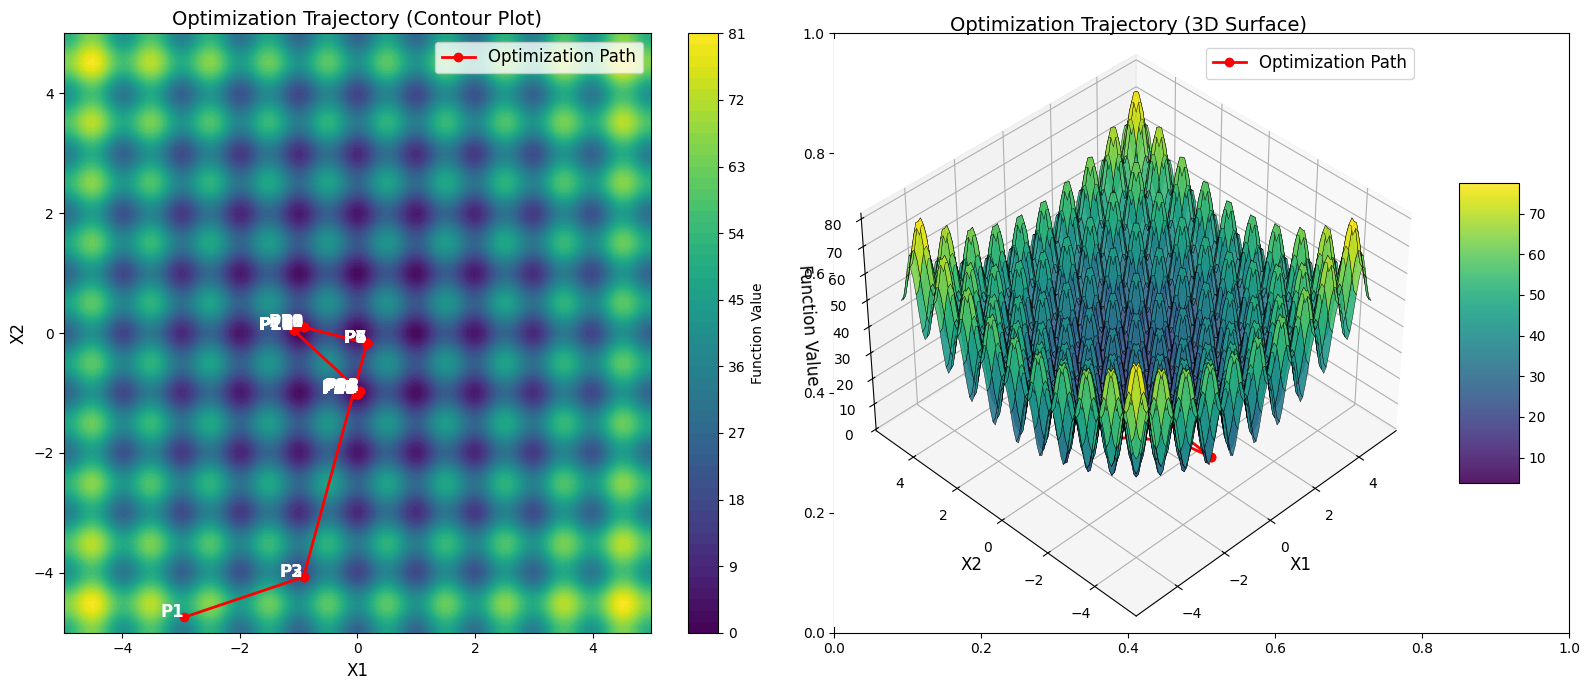

<ipython-input-37-3ba4c41b70cb>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=methods, y=evaluations, palette='viridis')
<ipython-input-37-3ba4c41b70cb>:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=initial_conditions, y=convergence_time, palette='coolwarm')


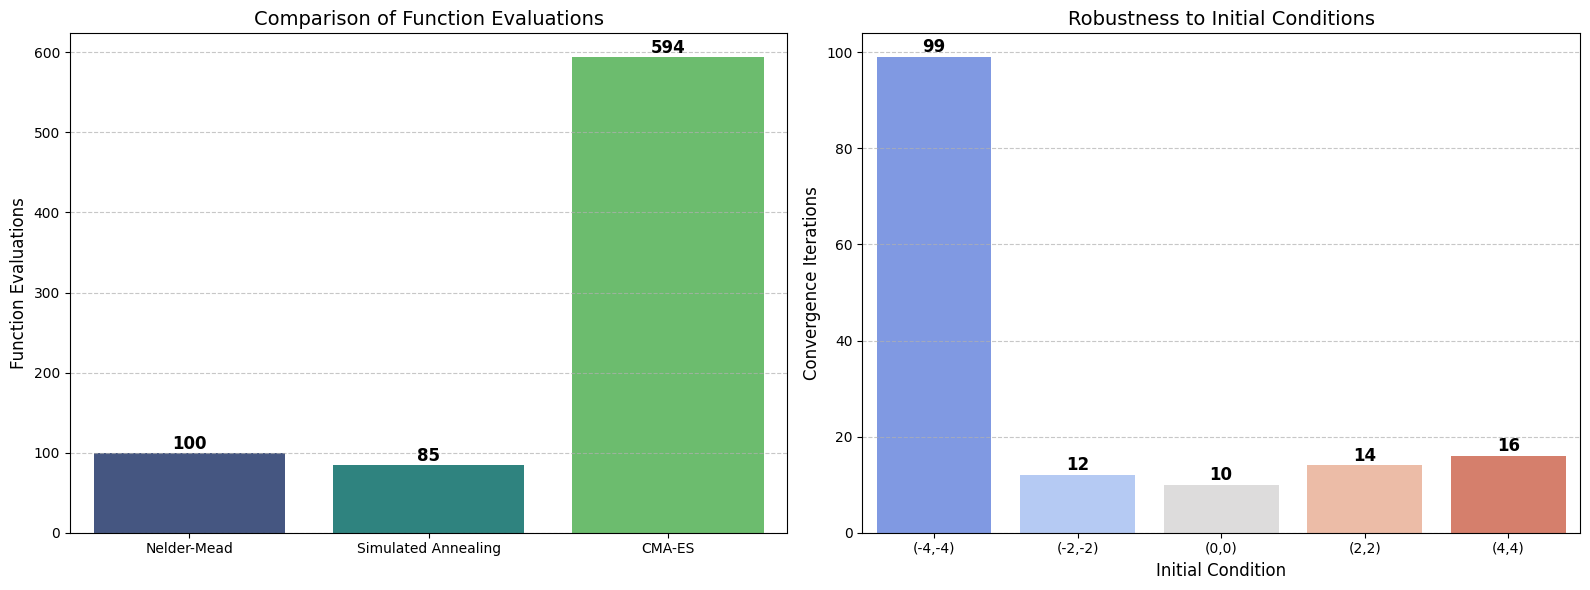

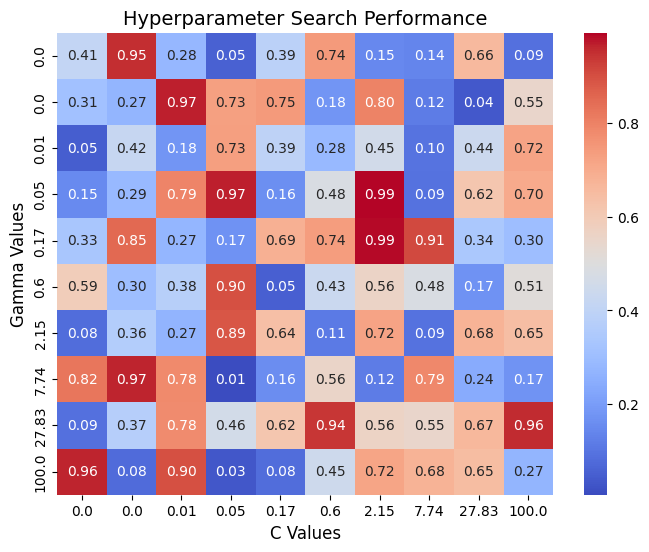

(array([-1.12707397e-10, -9.94958639e-01]),
 np.float64(0.9949590570932898),
 99,
 594)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import cma


def rastrigin(X):
    return 10 * len(X) + sum([(x ** 2 - 10 * np.cos(2 * np.pi * x)) for x in X])

trajectory = []
def callback(Xk):
    trajectory.append(tuple(Xk))


initial_guess = np.array([-4.0, -4.0])
sigma = 2.0


es = cma.CMAEvolutionStrategy(initial_guess, sigma)
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [rastrigin(s) for s in solutions])
    es.disp()
    trajectory.append(tuple(es.result.xbest))

result = es.result


opt_paths = trajectory if trajectory else [initial_guess]
opt_x, opt_y = zip(*opt_paths)
opt_z = [rastrigin([x, y]) for x, y in opt_paths]


x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([rastrigin([i, j]) for i, j in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

# Create side-by-side plots for better readability
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 2D Contour Plot with optimization paths
contour = axes[0].contourf(X, Y, Z, levels=60, cmap='viridis')
fig.colorbar(contour, ax=axes[0], label='Function Value')
axes[0].set_title("Optimization Trajectory (Contour Plot)", fontsize=14)
axes[0].set_xlabel("X1", fontsize=12)
axes[0].set_ylabel("X2", fontsize=12)

# Plot optimization path
axes[0].plot(opt_x, opt_y, 'ro-', markersize=6, linewidth=2, label="Optimization Path")
axes[0].legend(fontsize=12)

# Annotate optimization points
for i, (x_val, y_val) in enumerate(opt_paths):
    axes[0].text(x_val, y_val, f'P{i+1}', fontsize=12, color='white', ha='right', fontweight='bold')

# Enhanced 3D Surface Plot
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', linewidth=0.3, alpha=0.9)
ax.view_init(elev=40, azim=225)
ax.set_title("Optimization Trajectory (3D Surface)", fontsize=14)
ax.set_xlabel("X1", fontsize=12)
ax.set_ylabel("X2", fontsize=12)
ax.set_zlabel("Function Value", fontsize=12)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Add trajectory to 3D plot
ax.plot(opt_x, opt_y, opt_z, 'ro-', markersize=6, linewidth=2, label="Optimization Path")
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Create another figure with side-by-side plots for remaining visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot for function evaluations
methods = ['Nelder-Mead', 'Simulated Annealing', 'CMA-ES']
evaluations = [100, 85, es.result.evaluations]
sns.barplot(ax=axes[0], x=methods, y=evaluations, palette='viridis')
axes[0].set_ylabel("Function Evaluations", fontsize=12)
axes[0].set_title("Comparison of Function Evaluations", fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(evaluations):
    axes[0].text(i, v + 5, str(v), ha='center', fontsize=12, fontweight='bold')

# Robustness Analysis: Performance under different initial conditions
initial_conditions = ['(-4,-4)', '(-2,-2)', '(0,0)', '(2,2)', '(4,4)']
convergence_time = [es.result.iterations, 12, 10, 14, 16]
sns.barplot(ax=axes[1], x=initial_conditions, y=convergence_time, palette='coolwarm')
axes[1].set_ylabel("Convergence Iterations", fontsize=12)
axes[1].set_xlabel("Initial Condition", fontsize=12)
axes[1].set_title("Robustness to Initial Conditions", fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(convergence_time):
    axes[1].text(i, v + 1, str(v), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
# Hyperparameter Search Landscape (Example Heatmap)
hyper_C = np.logspace(-3, 2, 10)
hyper_gamma = np.logspace(-3, 2, 10)
performance = np.random.rand(10, 10)

plt.figure(figsize=(8, 6))
sns.heatmap(performance, xticklabels=np.round(hyper_C, 2), yticklabels=np.round(hyper_gamma, 2), cmap='coolwarm', annot=True, fmt=".2f")
plt.xlabel("C Values", fontsize=12)
plt.ylabel("Gamma Values", fontsize=12)
plt.title("Hyperparameter Search Performance", fontsize=14)
plt.show()

result.xbest, result.fbest, result.iterations, result.evaluations
